In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
import xgboost as xgb
from xgboost import XGBClassifier
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

In [3]:
train_dir = "/kaggle/input/coffee-bean-tanvir/train"
test_dir = "/kaggle/input/coffee-bean-tanvir/test"

# Training Data Generator (with validation split)
# ======================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   # 20% of training data for validation
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'    # <-- this is the training subset
)

# Validation generator
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # <-- this is the validation subset
)

# ======================
# Test Data Generator (final evaluation)
# ======================
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Quick sanity check
# ======================
print("Train classes mapping:", train_gen.class_indices)
print("Validation classes mapping:", val_gen.class_indices)
print("Test classes mapping:", test_gen.class_indices)

Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Train classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Validation classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Test classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}


In [4]:
def se_block(feature_map, ratio=8):
    channel = feature_map.shape[-1]
    
    # Squeeze: Global Average Pooling
    se = layers.GlobalAveragePooling2D()(feature_map)
    se = layers.Reshape((1,1,channel))(se)
    
    # Excitation: Two FC layers
    se = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)(se)
    se = layers.Dense(channel, activation='sigmoid', kernel_initializer='he_normal', use_bias=True)(se)
    
    # Scale feature map
    x = layers.Multiply()([feature_map, se])
    return x

In [5]:
def build_se_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Conv Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)

    # Conv Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)

    # Conv Block 3
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)

    # Global Average Pooling (feature output)
    gap = layers.GlobalAveragePooling2D()(x)

    # Dense head for training only
    dense = layers.Dense(256, activation='relu')(gap)
    dense = layers.Dropout(0.5)(dense)
    outputs = layers.Dense(num_classes, activation='softmax')(dense)

    model = models.Model(inputs, outputs)
    return model

In [6]:
num_classes = train_gen.num_classes
se_model = build_se_cnn(input_shape=(128,128,3), num_classes=num_classes)

se_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = se_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1
)

I0000 00:00:1756685886.769541      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756685894.152516     113 service.cc:148] XLA service 0x7e6e8c04a030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756685894.153510     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756685894.769677     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/30 ━━━━━━━━━━━━━━━━━━━━ 4:40 10s/step - accuracy: 0.2500 - loss: 1.3839

I0000 00:00:1756685898.626439     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - accuracy: 0.2521 - loss: 1.3868 - val_accuracy: 0.2500 - val_loss: 1.3799
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - accuracy: 0.2831 - loss: 1.3591 - val_accuracy: 0.4167 - val_loss: 1.1517
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.5293 - loss: 0.9802 - val_accuracy: 0.5708 - val_loss: 0.8442
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - accuracy: 0.6302 - loss: 0.7135 - val_accuracy: 0.7667 - val_loss: 0.6355
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 260ms/step - accuracy: 0.6706 - loss: 0.6692 - val_accuracy: 0.7750 - val_loss: 0.6239
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.7795 - loss: 0.5803 - val_accuracy: 0.7833 - val_loss: 0.5502
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.8502 - loss: 0.3724 - val_accuracy: 0.8792 - val_loss: 0.2992
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.8998 - loss: 0.2664 - val_accuracy: 0.8917 - val

In [7]:
feature_extractor = models.Model(
    inputs=se_model.input,
    outputs=se_model.layers[-4].output   # GAP output before Dense
)
def extract_features(model, generator):
    features = []
    labels = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        feat = model.predict(x_batch, verbose=0)
        features.append(feat)
        labels.append(np.argmax(y_batch, axis=1))
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels
X_train, y_train = extract_features(feature_extractor, train_gen)
X_val, y_val     = extract_features(feature_extractor, val_gen)
X_test, y_test   = extract_features(feature_extractor, test_gen)

In [8]:
# Apply MinMaxScaler to the extracted features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
# XGBoost Classifier
# ======================
xgb_clf = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

xgb_clf.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [10]:
# ---- Training ----
start_time = time.time()
xgb_clf = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)
xgb_clf.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
print(f"Training Time: {train_time:.4f} seconds")

# ---- Validation ----
start_time = time.time()
y_val_pred = xgb_clf.predict(X_val_scaled)
val_time = time.time() - start_time
print(f"Validation Prediction Time: {val_time:.4f} seconds")
print("Validation Accuracy (XGBoost):", accuracy_score(y_val, y_val_pred))

# ---- Testing ----
start_time = time.time()
y_test_pred = xgb_clf.predict(X_test_scaled)
test_time = time.time() - start_time
print(f"Test Prediction Time: {test_time:.4f} seconds")
print("Test Accuracy (XGBoost):", accuracy_score(y_test, y_test_pred))

# ---- Classification Report ----
print(classification_report(y_test, y_test_pred, target_names=list(train_gen.class_indices.keys())))

Training Time: 0.3609 seconds
Validation Prediction Time: 0.0028 seconds
Validation Accuracy (XGBoost): 0.9708333333333333
Test Prediction Time: 0.0013 seconds
Test Accuracy (XGBoost): 0.9425
              precision    recall  f1-score   support

        Dark       0.95      0.96      0.96       100
       Green       1.00      0.92      0.96       100
       Light       1.00      0.94      0.97       100
      Medium       0.84      0.95      0.89       100

    accuracy                           0.94       400
   macro avg       0.95      0.94      0.94       400
weighted avg       0.95      0.94      0.94       400



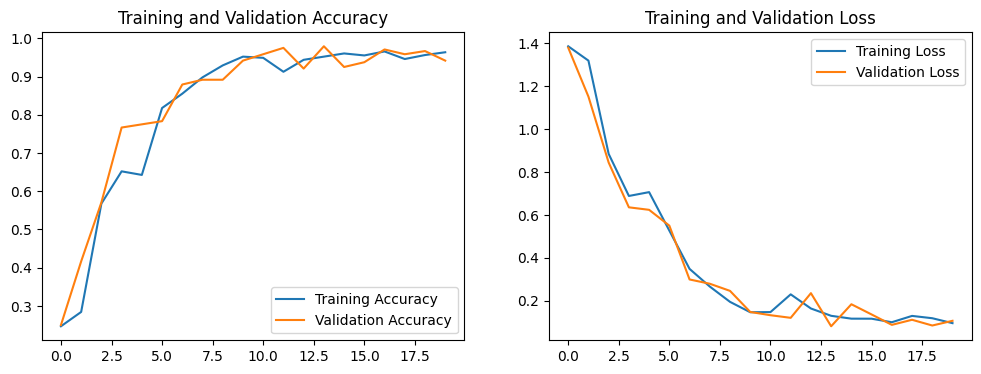

In [11]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# ---- Predictions ----
y_test_pred_xgb = xgb_model.predict(X_test_scaled)
# For probability estimates, use predict_proba
y_test_proba_xgb = xgb_model.predict_proba(X_test_scaled)


# ---- Basic Metrics ----
print("Accuracy:", accuracy_score(y_test, y_test_pred_xgb))
print("Precision:", precision_score(y_test, y_test_pred_xgb, average='macro'))
print("Recall:", recall_score(y_test, y_test_pred_xgb, average='macro'))
print("F1-score:", f1_score(y_test, y_test_pred_xgb, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_xgb))

# ---- ROC-AUC Curves ----
# Binarize labels for multi-class ROC
classes_present = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes_present)

# Only plot ROC if at least 2 classes are present
if y_test_bin.shape[1] > 1:
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba_xgb[:, i])
        plt.plot(fpr, tpr, label=f"Class {list(train_gen.class_indices.keys())[classes_present[i]]} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend()
    plt.show()

    # Compute overall ROC-AUC
    print("Test AUC:", roc_auc_score(y_test_bin, y_test_proba_xgb, multi_class='ovr'))
else:
    print("ROC-AUC skipped: less than 2 classes present in test set")

NameError: name 'xgb_model' is not defined